# 02 SSVEP Offline Processing

Welcome to this tutorial on processing Steady-State Visual Evoked 
Potentials (SSVEP)! SSVEP works by presenting stimuli at different frequencies
to the user. The known target frequencies are used together with the resultant EEG 
to determine the patterns associated with each stimulus frequency.

## Requirements
- If you have not already, you will have to install the **ipykernel** package to
run this notebook. You can do this from your terminal with `pip install ipykernel`
- To view interactive plots you need to install **ipyml** with `pip install ipympl`

## Loading a session of SSVEP Data

First, lets load in our SSVEP example data from the appropriate XDF. Just like the previous tutorial, we will check the number of channels, channel labels, and sampling rate. 

In [3]:
# Get the path of the file we want to open
# Using the python `os` module to create an OS-agnostic filepath

# Import module
import os

from bci_essentials.utils.logger import Logger  # Logger wrapper

# Instantiate a logger for the module at the default level of logging.INFO
logger = Logger()

# Create OS-agnostic path to the folder that holds the example data
# This assumes the tutorial is run from the folder within bci-essentials-python
# that it was original located
example_data_folder_path = os.path.join("..", "examples", "data")

# The filename of the data used in this tutorial
tutorial_filename = "ssvep_example.xdf"

# Construct the filepath
tutorial_data_filepath = os.path.join(example_data_folder_path, tutorial_filename)

# Log the path to the file used
logger.info(
      "Using data file:\n\t%s\nLocated in the relative path:\n\t%s",
      tutorial_filename,
      tutorial_data_filepath
)

2023-12-12 14:50:38 - INFO - bci_essentials : Using data file:
	ssvep_example.xdf
Located in the relative path:
	..\examples\data\ssvep_example.xdf


Lets start by inspecting the EEG. Similarly to Tutorial 1, we can pull our raw EEG data using the XDF EEG source

In [4]:
# Import the XDF EEG source class
from bci_essentials.io.xdf_sources import XdfEegSource

eeg_source = XdfEegSource(tutorial_data_filepath)

[eeg_samples, eeg_timestamps] = eeg_source.get_samples()
nchannels = eeg_source.nchannels
fsample = eeg_source.fsample
channel_labels = eeg_source.channel_labels
channel_types = eeg_source.channel_types
channel_units = eeg_source.channel_units

# Check that it worked by logging the channel labels and sampling rate
logger.info("The number of channels is: %s", nchannels)
logger.info("The sampling rate is: %s", fsample)
logger.info("The channel labels are: %s", channel_labels)
logger.info("The channel types are: %s", channel_types)
logger.info("The channel units are: %s", channel_units)

2023-12-12 14:50:43 - INFO - bci_essentials : The number of channels is: 16
2023-12-12 14:50:43 - INFO - bci_essentials : The sampling rate is: 256.0
2023-12-12 14:50:43 - INFO - bci_essentials : The channel labels are: ['PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Cp4', 'C4', 'F4', 'Cp3', 'C3', 'F3', 'Cz', 'Fz']
2023-12-12 14:50:43 - INFO - bci_essentials : The channel types are: ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']
2023-12-12 14:50:43 - INFO - bci_essentials : The channel units are: ['microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts']


## Inspect the whole EEG

First, let's take a look at the EEG to see if anything stands out.



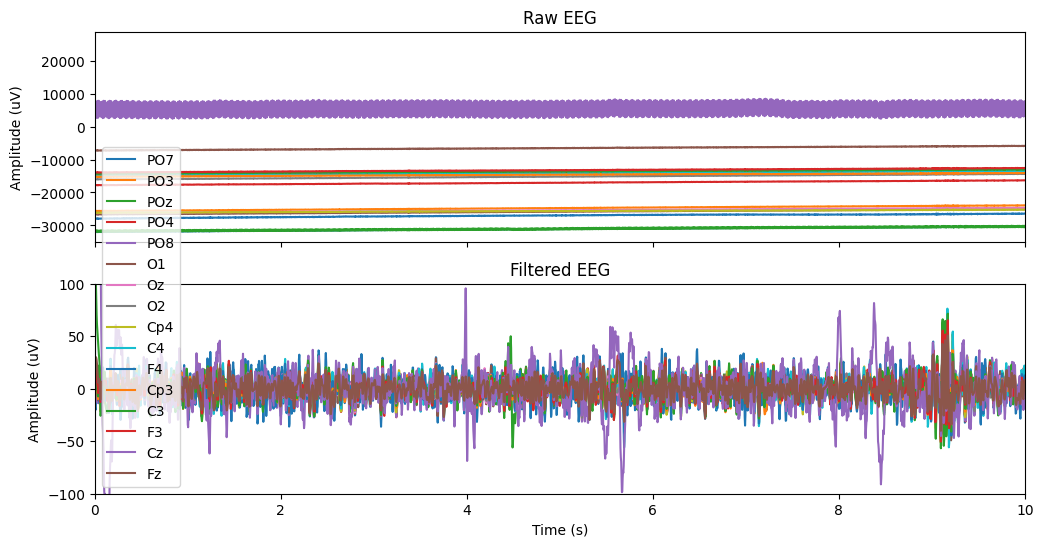

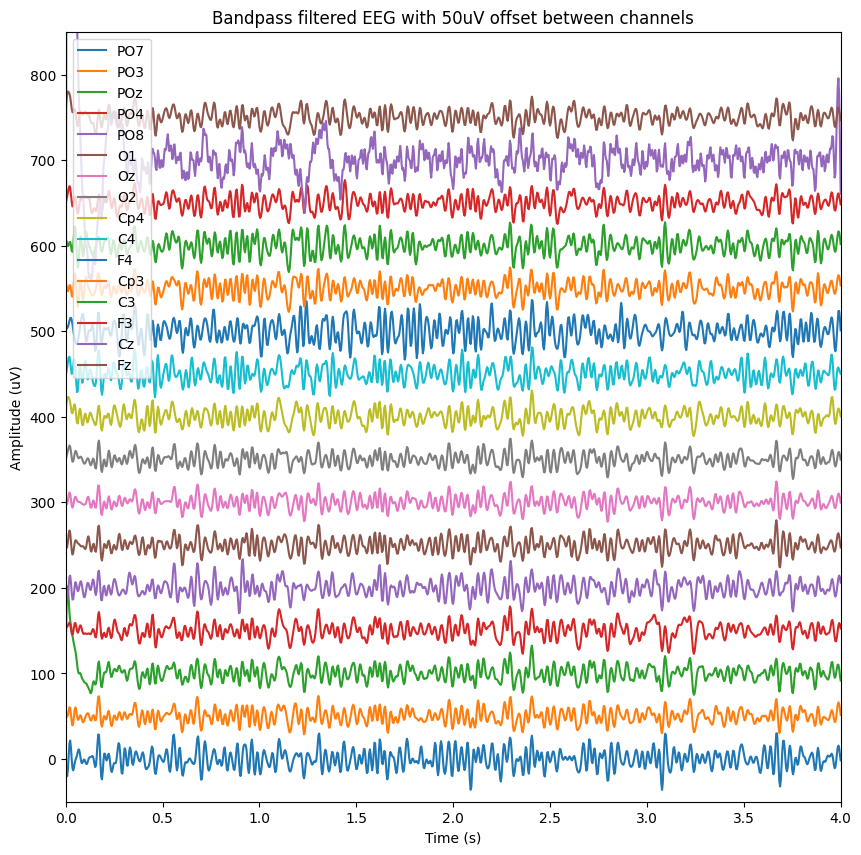

In [5]:
from bci_essentials.signal_processing import bandpass
from matplotlib import pyplot as plt
import numpy as np

raw_eeg = eeg_samples
timestamps = eeg_timestamps - eeg_timestamps[0]

# Bandpass filter between 1 and 40 Hz
bp_filt_eeg = bandpass(raw_eeg.T, 4, 40, 5, fsample).T

# Plot the raw and filtered EEG
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax[0].plot(timestamps, raw_eeg)
ax[0].set_title('Raw EEG')
ax[0].set_ylabel('Amplitude (uV)')
ax[0].set_xlim([0, 10])
ax[1].plot(timestamps, bp_filt_eeg)
ax[1].set_title('Filtered EEG')
ax[1].set_ylabel('Amplitude (uV)')
ax[1].set_xlabel('Time (s)')
ax[1].set_xlim([0, 10])
ax[1].set_ylim([-100, 100])
ax[1].legend(channel_labels)
plt.show()

# Plot the bandpass_filt_eeg again but with 50uV of offset between each channel
plt.figure(figsize=(10, 10))
plt.plot(timestamps, bp_filt_eeg + np.arange(0, 50 * 16, 50))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Bandpass filtered EEG with 50uV offset between channels')
plt.xlim([0, 4])
plt.ylim([-50, 850])
plt.legend(channel_labels)
plt.show()




Well that looks pretty good, except for Cz, so we will have to remember that going forward.

Next up, lets look at the frequency properties of the signal. Let's start by plotting the 
power spectral density (PSD) of O1 and O2, where we expect to see the majority of the SSVEP
signal.

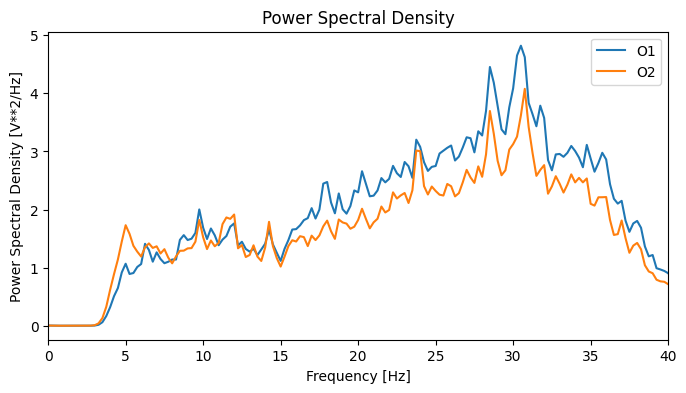

In [6]:
from scipy.signal import welch

O1_eeg = bp_filt_eeg[:, channel_labels.index('O1')]
O2_eeg = bp_filt_eeg[:, channel_labels.index('O2')]

# Compute the PSD of O1 and O2
freqs, O1_eeg_psd = welch(O1_eeg, fsample, nperseg=2048)
freqs, O2_eeg_psd = welch(O2_eeg, fsample, nperseg=2048)

freqs, O1_eeg_psd = welch(O1_eeg, fsample, nperseg=1024)
freqs, O2_eeg_psd = welch(O2_eeg, fsample, nperseg=1024)



# Plot the PSD of the filtered EEG data
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(freqs, np.abs(O1_eeg_psd), label='O1')
ax.plot(freqs, np.abs(O2_eeg_psd), label='O2')
ax.set_xlim([0, 40])
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power Spectral Density [V**2/Hz]')
ax.set_title('Power Spectral Density')
ax.legend()

plt.show()

Cool! It looks like we have some peaks in the PSD of the signal, hopefully they
correspond to our SSVEP stimulation frequencies.

Unfortunately the PSDs can only show so much, as they show the frequency of the 
signal as a whole. They do not show when these spikes in frequency are occuring. For this we need a spectrogram.

Spectrograms are a tool to visualize the time and frequency content of a signal
simultaneuously. However, they can be tricky to plot because in signal processing 
there is an inevitable tradeoff between reolution in the time and frequency domains.
This tradeoff is determined by the `nfft`, which is automatically set to equal 
`nperseg`. Increasing this value will increase our frequency resolution, while 
decreasing our temporal resolution.



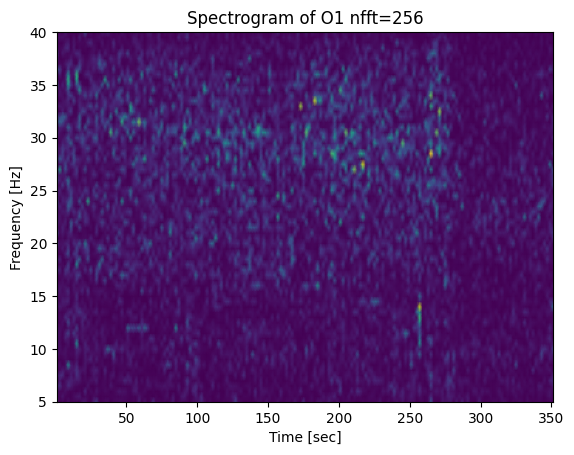

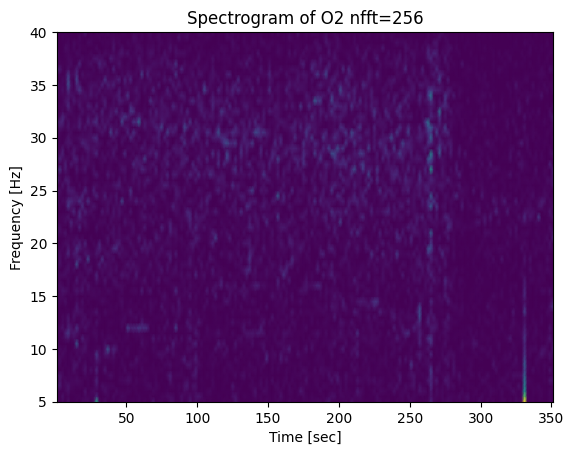

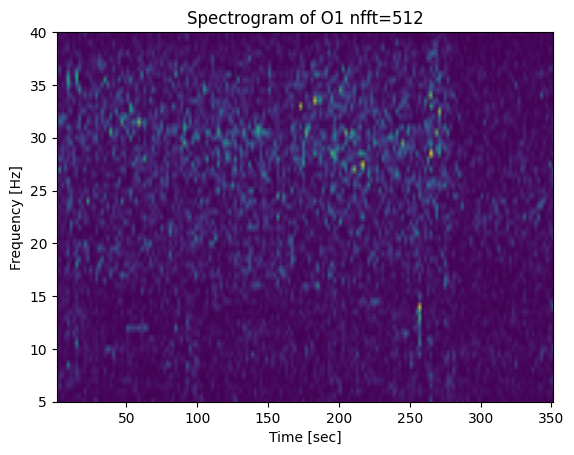

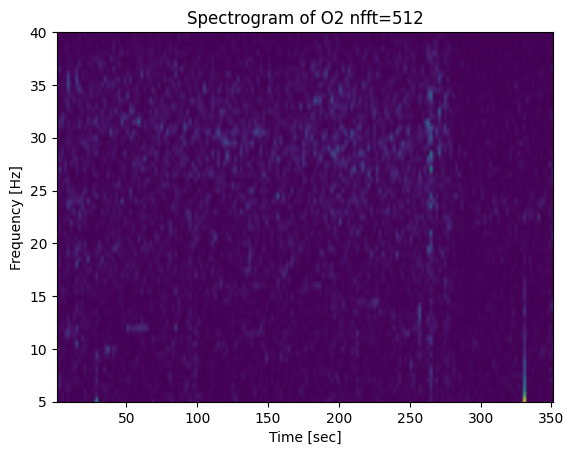

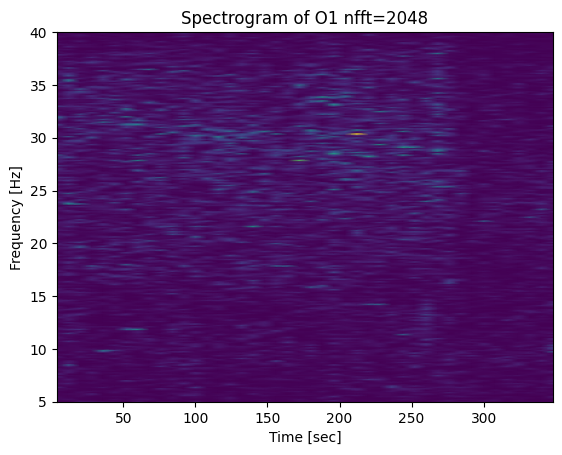

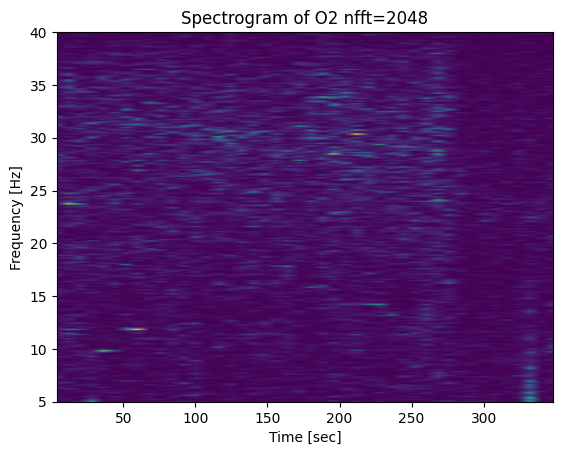

In [7]:
# Plot spectrograms of O1 and O2

from scipy.signal import spectrogram

f, t, Sxx_O1 = spectrogram(O1_eeg, fs=fsample, nperseg=512, noverlap=0)
plt.pcolormesh(t, f, Sxx_O1, shading='gouraud')
plt.title('Spectrogram of O1 nfft=256')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([5, 40])
plt.show()

f, t, Sxx_O2 = spectrogram(O2_eeg, fs=fsample, nperseg=512, noverlap=0)
plt.title('Spectrogram of O2 nfft=256')
plt.pcolormesh(t, f, Sxx_O2, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([5, 40])
plt.show()

f, t, Sxx_O1 = spectrogram(O1_eeg, fs=fsample, nperseg=512, noverlap=0)
plt.pcolormesh(t, f, Sxx_O1, shading='gouraud')
plt.title('Spectrogram of O1 nfft=512')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([5, 40])
plt.show()

f, t, Sxx_O2 = spectrogram(O2_eeg, fs=fsample, nperseg=512, noverlap=0)
plt.title('Spectrogram of O2 nfft=512')
plt.pcolormesh(t, f, Sxx_O2, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([5, 40])
plt.show()

f, t, Sxx_O1 = spectrogram(O1_eeg, fs=fsample, nperseg=2048, noverlap=0)
plt.pcolormesh(t, f, Sxx_O1, shading='gouraud')
plt.title('Spectrogram of O1 nfft=2048')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([5, 40])
plt.show()

f, t, Sxx_O2 = spectrogram(O2_eeg, fs=fsample, nperseg=2048, noverlap=0, mode='psd')
plt.title('Spectrogram of O2 nfft=2048')
plt.pcolormesh(t, f, Sxx_O2, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([5, 40])
plt.show()

These spectrograms look good! See how we can see short little bars, like
the one around 50 s and 12 Hz. These are not easily visible at lower 
frequency resolutions. They are very likely to be from the user staring
at a specific stimulus for a period of time.

Now that we have speculated enough about this EEG, let's see if it is classified
correctly!

To do any classifications with Bessy, we need an EegData object. This class requires the following classes injected into it as well.<br>
<ul>
<li>classifier - the classifier we want to use</li>
<li>eeg_source - the source object from which we will pull eeg</li>
<li>marker_source - the source object from which we will pull marker data</li>
</ul>

Once the EegData object exists, we can get it to pull in the data, preprocess it, and build a classification model when we run main().


In [9]:
# Import the eeg_data module to load and process the data
from bci_essentials.eeg_data import EegData
from bci_essentials.classification.ssvep_riemannian_mdm_classifier import (
    SsvepRiemannianMdmClassifier,
)
from bci_essentials.io.xdf_sources import XdfEegSource, XdfMarkerSource

# Initialize the classifier, eeg_source, and marker_source
classifier = SsvepRiemannianMdmClassifier()
classifier.set_ssvep_settings(
    n_splits=3, random_seed=42, n_harmonics=3, f_width=0.5
)

eeg_source = XdfEegSource(tutorial_data_filepath)

marker_source = XdfMarkerSource(tutorial_data_filepath)

# Initialize data object
ssvep_data = EegData(classifier, eeg_source, marker_source)

# Run the data processing pipeline
ssvep_data.main(
    online=False,
    training=True,
    max_samples=5120,
    pp_type="bandpass",
    pp_low=4,
    pp_high=40,
)

# Get the target frequencies, note that this must be done after main, so that the classifier data fields are populated
target_freqs = classifier.target_freqs

# Log the target freqs
logger.info("The target frequencies are: %s", target_freqs)

2023-12-12 14:59:32 - INFO - bci_essentials.classification.generic_classifier : Initializing the classifier
2023-12-12 14:59:33 - INFO - bci_essentials.eeg_data : g.USBamp-1
2023-12-12 14:59:33 - INFO - bci_essentials.eeg_data : ['PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Cp4', 'C4', 'F4', 'Cp3', 'C3', 'F3', 'Cz', 'Fz']
2023-12-12 14:59:33 - INFO - bci_essentials.eeg_data : Marker: Trial Started
2023-12-12 14:59:33 - INFO - bci_essentials.eeg_data : Marker information: ['ssvep', '12', '5', '4', '24', '20.57143', '18', '16', '14.4', '12', '10.28571', '9', '8', '7.2', '6', '4.965517']
2023-12-12 14:59:33 - INFO - bci_essentials.eeg_data : Marker information: ['ssvep', '12', '5', '4', '24', '20.57143', '18', '16', '14.4', '12', '10.28571', '9', '8', '7.2', '6', '4.965517']
2023-12-12 14:59:33 - INFO - bci_essentials.eeg_data : Marker information: ['ssvep', '12', '5', '4', '24', '20.57143', '18', '16', '14.4', '12', '10.28571', '9', '8', '7.2', '6', '4.965517']
2023-12-12 14:59:

The printout above shows the markers from BCI Essentials Unity.

The markers for SSVEP are in the format:

`['ssvep', # of frequencies/objects, index of target object, length of window in seconds, [list (length = # of objects) of frequencies in Hz]]`

The printout also shows the classification accuracy, which is ... terrible.
But fret not, because this is a poorly designed trial for an actual BCI
for reasons we will see soon.

For now, lets see if the actual stimulus frequencies, which were found in 
ssvep_data.classifier.target_freqs match the peaks that we saw in the PSD.

As fun little bonus we will plot both the PSD and the PSD detrended with a 
Savitsky-Golay filter.


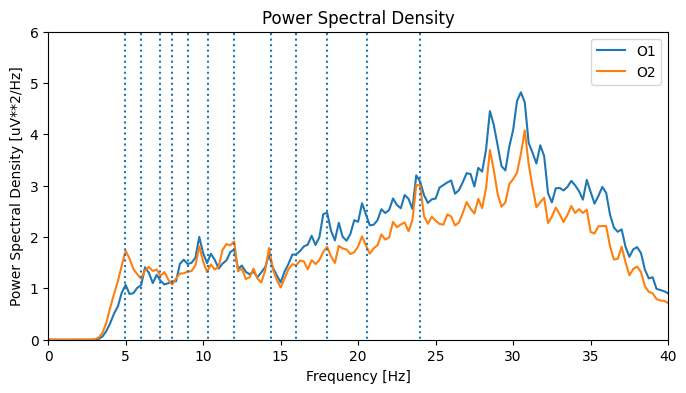

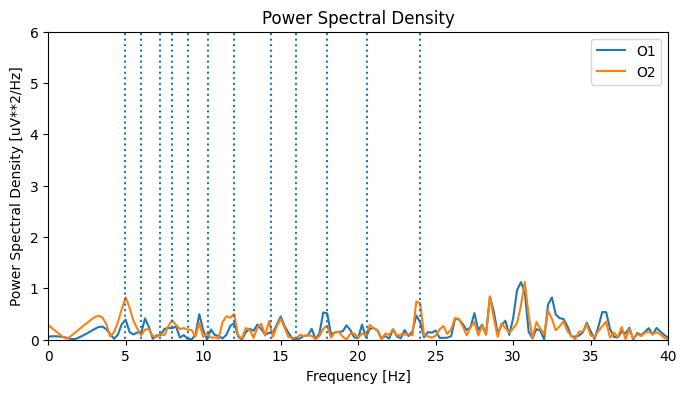

In [10]:
import scipy.signal

# See if this make sense based on our PSD
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(freqs, np.abs(O1_eeg_psd), label='O1')
ax.plot(freqs, np.abs(O2_eeg_psd), label='O2')
for tf in target_freqs:
    ax.vlines(x=tf, ymin=-10, ymax=100, linestyles='dotted')
ax.set_xlim([0, 40])
ax.set_ylim([0, 6])
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power Spectral Density [uV**2/Hz]')
ax.set_title('Power Spectral Density')
ax.legend()

# Now plot again, but with detrended data
O1_eeg_psd_detrended = O1_eeg_psd - scipy.signal.savgol_filter(O1_eeg_psd, window_length=51, polyorder=3)
O2_eeg_psd_detrended = O2_eeg_psd - scipy.signal.savgol_filter(O2_eeg_psd, window_length=51, polyorder=3)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(freqs, np.abs(O1_eeg_psd_detrended), label='O1')
ax.plot(freqs, np.abs(O2_eeg_psd_detrended), label='O2')
for tf in target_freqs:
    ax.vlines(x=tf, ymin=-10, ymax=100, linestyles='dotted')
ax.set_xlim([0, 40])
ax.set_ylim([0, 6])
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power Spectral Density [uV**2/Hz]')
ax.set_title('Power Spectral Density')
ax.legend()

Cool! 

We see that some, but not all of the peaks allign with our target frequencies.

This is because of ... 

HARMONICS!!!

Harmonics are frequencies at whole number multiples of the target frequency 
and in SSVEP they can be stronger or have higher SNRs than the target frequencies
themselves.

To visualize these, we will plot them on the PSD below, with target frequencies
in blue, first harmonics in red and second harmonics in green. We will also add 
a teeny tiney offset to the the plots of the second and third harmonics so that
they don't hide our other lines.

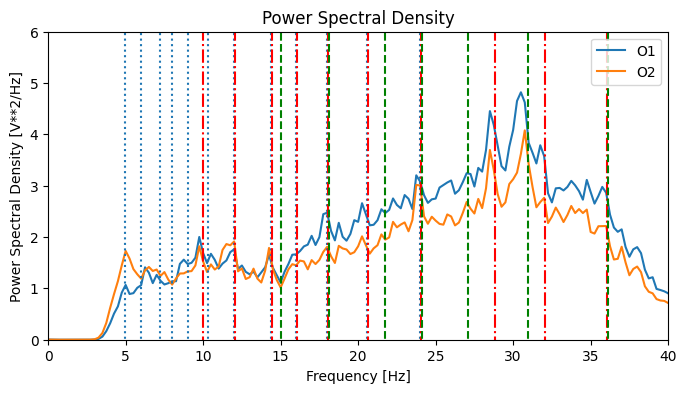

In [11]:
# Plot again but with harmonics in red vertical lines
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(freqs, np.abs(O1_eeg_psd), label='O1')
ax.plot(freqs, np.abs(O2_eeg_psd), label='O2')
for tf in target_freqs:
    ax.vlines(x=tf, ymin=-10, ymax=100, linestyles='dotted')
    # Plot the harmonics, a small amount of offset is added to show lines that would
    # otherwise be on top of each other
    ax.vlines(x=tf*2+0.05, ymin=-10, ymax=100, linestyles='dashdot', colors='r')
    ax.vlines(x=tf*3+0.1, ymin=-10, ymax=100, linestyles='dashed', colors='g')
ax.set_xlim([0, 40])
ax.set_ylim([0, 6])
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power Spectral Density [V**2/Hz]')
ax.set_title('Power Spectral Density')
ax.legend()

Now that's more like it! Now we can see that the most prominent of our PSD 
peaks are actually coming from the harmonics of our stimulus frequencies,
which is quite common. 

Unfortunately this also explains our poor classification accuracy. Since 
our second and third harmonics overlap for different frequencies this can 
be confusing for the classifier. 

This is a VERY important design consideration when choosing frequencies for
an SSVEP BCI.

Now we can look at the harmonics in the spectrograms to see if the little bars 
that we saw earlier on do in fact allign with stimulus frequencies or their harmonics!

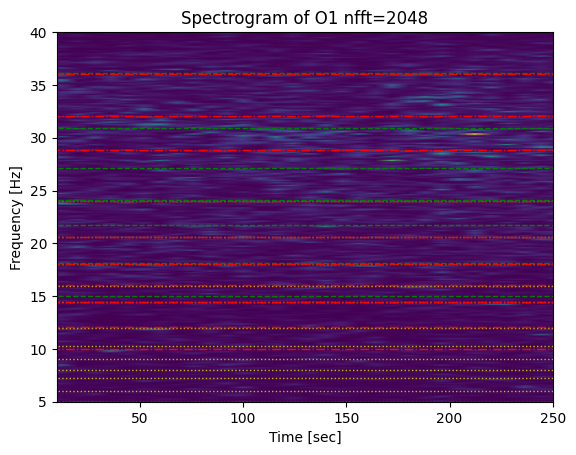

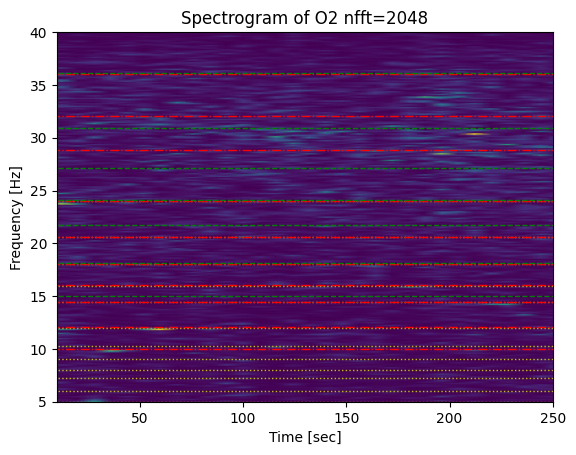

In [12]:
# Plot the spectrogram again, but with the target frequencies highlighted as red lines.

f, t, Sxx_O1 = spectrogram(O1_eeg, fs=ssvep_data.fsample, nperseg=2048, noverlap=0)
plt.pcolormesh(t, f, Sxx_O1, shading='gouraud')
for tf in target_freqs:
    plt.hlines(y=tf, xmin=0, xmax=400, color='y', linewidth=1, linestyle='dotted')
    plt.hlines(y=tf*2+0.05, xmin=0, xmax=400, color='r', linewidth=1, linestyle='dashdot')
    plt.hlines(y=tf*3+0.1, xmin=0, xmax=400, color='g', linewidth=1, linestyle='dashed')
plt.title('Spectrogram of O1 nfft=2048')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([5, 40])
plt.xlim([10,250])
plt.show()

f, t, Sxx_O2 = spectrogram(O2_eeg, fs=ssvep_data.fsample, nperseg=2048, noverlap=0, mode='psd')
for tf in target_freqs:
    plt.hlines(y=tf, xmin=0, xmax=400, color='y', linewidth=1, linestyle='dotted')
    plt.hlines(y=tf*2+0.05, xmin=0, xmax=400, color='r', linewidth=1, linestyle='dashdot')
    plt.hlines(y=tf*3+0.1, xmin=0, xmax=400, color='g', linewidth=1, linestyle='dashed')
plt.title('Spectrogram of O2 nfft=2048')
plt.pcolormesh(t, f, Sxx_O2, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([5, 40])
plt.xlim([10,250])
plt.show()

And they do! Or  at least some of them do – it seems we are missing quite 
a few bars. Perhaps our signal to noise ratio is not that great because 
of the background noise of all of those flashing stimuli.

Next, lets take a look at some of the individual windows of SSVEP data
to see what their PSDs look like. We have four windows of data for each
target frequency so these PSDs are plotted below with thin lines; the 
thick lines represent the PSD of these four windows concatenated together.
The harmonics are also plotted as vertical lines.

This is a great exercise to see if we are getting the signal at the 
frequecies we expect. It can also help us to weed out bad choices for
stimulus frequencies. As you look at the plots below, try to think of
which subset of frequencies (choose 3 or 4) you would use and why?

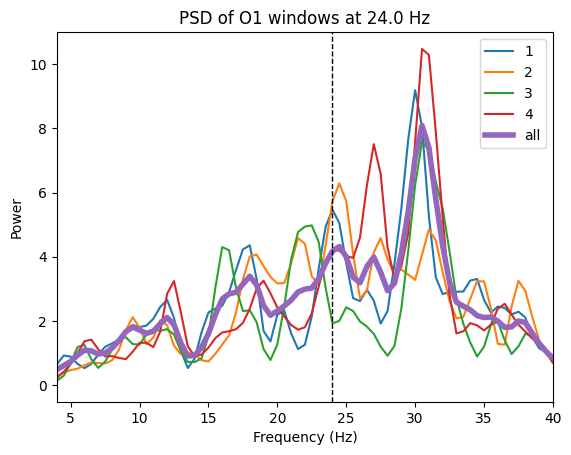

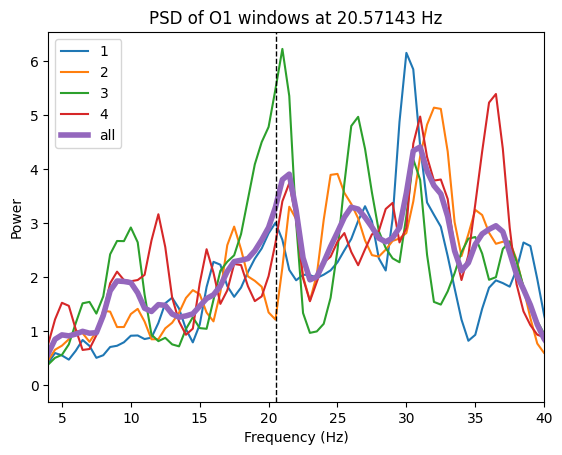

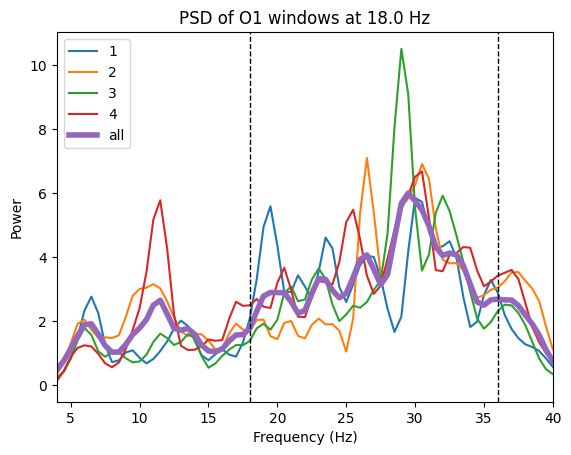

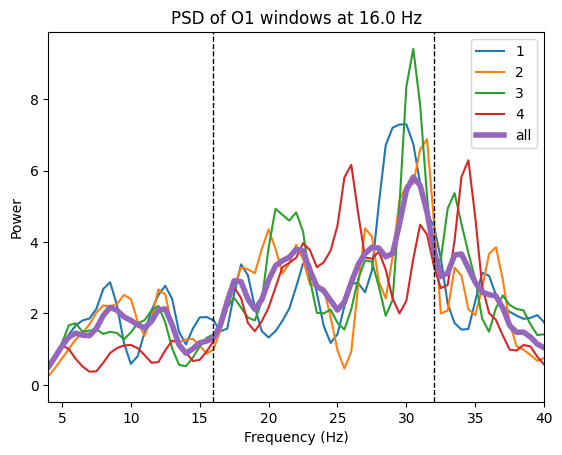

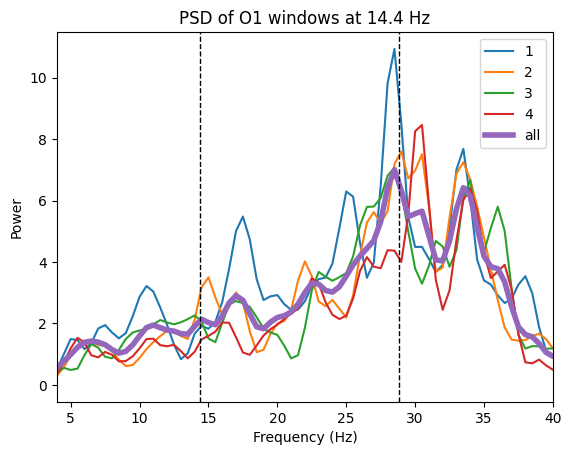

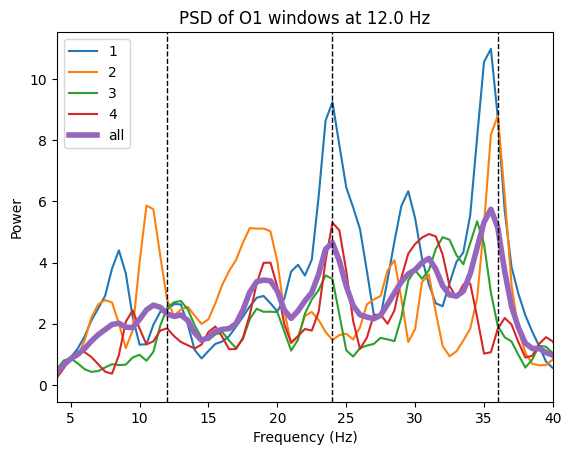

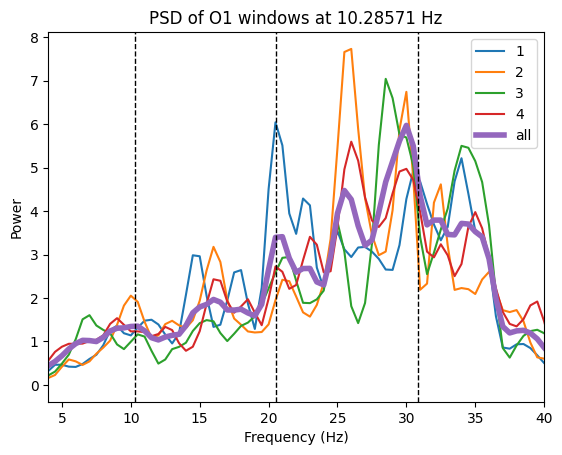

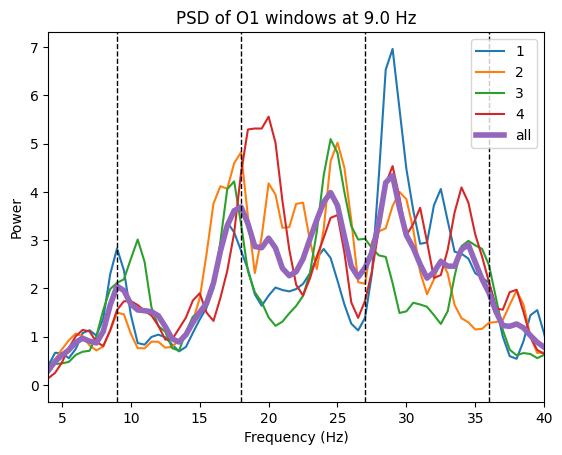

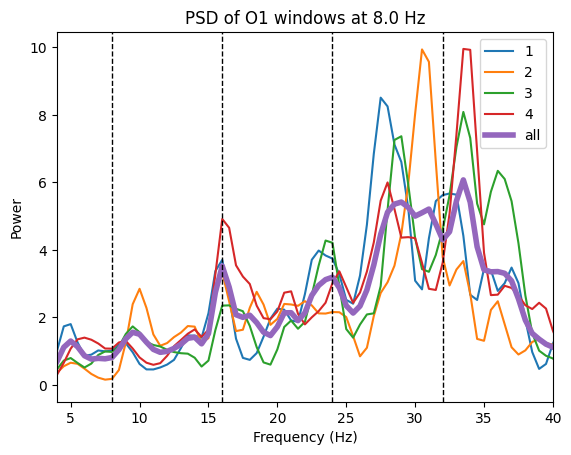

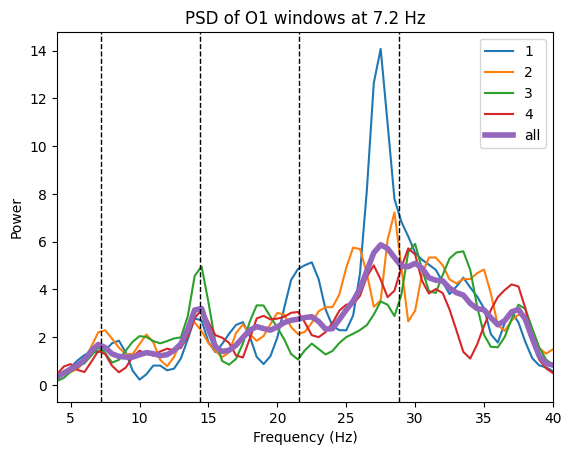

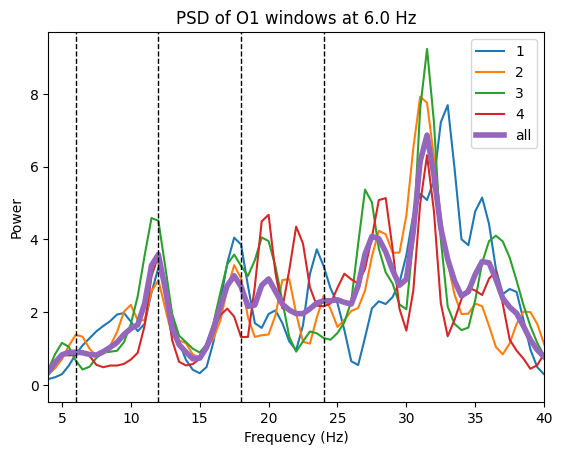

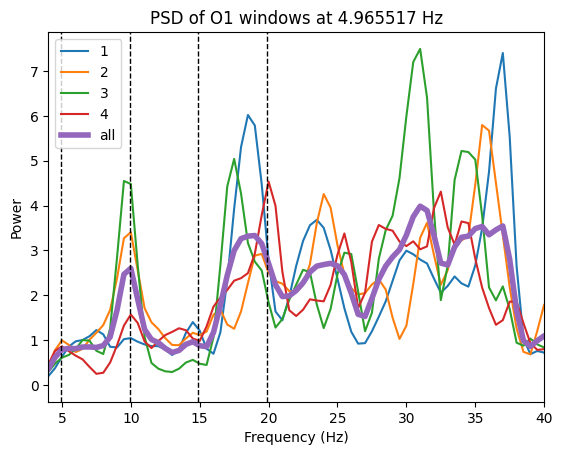

In [14]:
# Plot PSDs of segments according to labels

windows = classifier.X
labels = classifier.y

window_freqs = [] 

for label in labels:
    target_freq_of_window = target_freqs[int(label)]
    window_freqs.append(target_freq_of_window)

# Plot the PSDs of the windows

unique_labels = np.unique(labels)
unique_labels = unique_labels.astype(int)

for unique_label in unique_labels:
    #Plot the PSDs of each window on the same plot
    windows_with_label = windows[labels == unique_label]

    for window in windows_with_label:
        freqs, psd = scipy.signal.welch(window[ssvep_data.channel_labels.index('O1'), :], fs=ssvep_data.fsample, nfft=512)
        plt.plot(freqs, psd)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power')
        plt.xlim([4,40])
        plt.title('PSD of O1 windows at {} Hz'.format(target_freqs[unique_label]))

    # Plot the PSD of the concatenated windows in bold
    concat_windows = np.concatenate(windows_with_label, axis=1)
    freqs, psd = scipy.signal.welch(concat_windows[ssvep_data.channel_labels.index('O1'), :], fs=ssvep_data.fsample, nfft=512)
    plt.plot(freqs, psd, linewidth=4)

    # Plot the target frequency and harmonics as vertical lines
    tf = target_freqs[unique_label]
    plt.axvline(tf, color='k', linestyle='--', linewidth=1)
    plt.axvline(tf*2, color='k', linestyle='--', linewidth=1)
    plt.axvline(tf*3, color='k', linestyle='--', linewidth=1)
    plt.axvline(tf*4, color='k', linestyle='--', linewidth=1)



    plt.legend([1,2,3,4,"all"])
    plt.show()

That's it! Hopefully you now feel more prepared to investigate the time/frequency
nature of signals, evaluate SSVEP data, and choose stimulus frequencies 
for your own SSVEP experiments.